In [5]:
%pip install numpy matplotlib scipy pandas scikit-learn seaborn sympy mplcursors

Note: you may need to restart the kernel to use updated packages.


# Tutorial simplexowania

Simplex słuzy do maksymalizacji (czyli jeśli chcemy minimum to trzeba dać minus)

mamy ograniczenia w postaci równań i nierówności
zamieniamy na postać kanoniczną czyli równania postaci Ax = b, Ax + h_i <= b, Ax - h_i >= b

potem zamieniamy funkcję celu na postać kanoniczną
czyli funkcję celu przerzucając wszystko na lewą stronę i dodając zmienne sztuczne (razy 0)

tabelka postaci
| x1  | x2  | h1 | h2 | P | R    |
|-----|-----|----|----|---|------|
| 5   | 3   | 1  | 0  | 0 | 3500 |
| 1   | 2   | 0  | 1  | 0 | 4700 |
| -12 | -25 | 0  | 0  | 1 | 0    |

wybieramy kolumnę o największej wartości ujemnej
wybieramy wiersz o najmniejszym ilorazie b / a, gdzie `a` to wartość w kolumnie, a `b` to wartość w kolumnie `R`

dzielimy wiersz przez wartość w kolumnie, żeby otrzymać 1
wyzerowujemy wszystkie wartości w kolumnie poprzez operacje na wierszach, dodając odpowiednio pomnożony wiersz z wartością w kolumnie

powtarzamy aż wszystkie wartości w kolumnie wynikowej będą nieujemne

wtedy szukamy kolumn gdzie mamy tylko jedno 1 i reszta 0, to jest nasza optymalna wartość, reszta to 0


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import List, Tuple, Callable, Union
import mplcursors

def income(coefficients: List[float], variables: List[float]) -> float:
    return sum(c * v for c, v in zip(coefficients, variables))

def create_constraints(constraints: List[Union[Tuple[List[float], float], Tuple[List[float], Callable[[List[float]], float]]]]) -> List[Callable[[List[float]], float]]:
    def create_single_constraint(a: List[float], b: Union[float, Callable[[List[float]], float]]) -> Callable[[List[float]], float]:
        if callable(b):
            return lambda x: b(x)
        else:
            return lambda x: b - sum(a_i * x_i for a_i, x_i in zip(a, x))
    return [create_single_constraint(a, b) for a, b in constraints]

def print_optimization_results(x0: List[float], zysk: List[float], constraints: List[Tuple[List[float], float]], _2d=True, maximize=True):
    if maximize:
        factor = -1  # Reverse the sign for maximization
    else:
        factor = 1
    
    objective = lambda decision_vars, coefficients: factor * income(coefficients, decision_vars)
    
    # Create the constraints functions
    cons = create_constraints(constraints)

    # Convert constraints to a format accepted by 'minimize'
    scipy_constraints = [{'type': 'ineq', 'fun': con} for con in cons]

    # Run the optimization
    result = minimize(
        fun=objective,
        x0=x0,
        args=(zysk,),
        constraints=scipy_constraints,
        method='SLSQP'
    )

    if not maximize:
        fix_plotting = []
        for (a, b) in constraints:
            a = [-i for i in a]
            b = -b
            fix_plotting.append((a, b))
        constraints = fix_plotting

    optimum_point = result.x

    print("Optimization Result:", optimum_point)
    print("Objective Function Value at Optimum:", factor * result.fun)
    
    if _2d:
        # Calculate the intercepts with x and y axes
        x_intercepts = [b/a[0] if a[0] != 0 else float('inf') for a, b in constraints if a[0] > 0]
        y_intercepts = [b/a[1] if a[1] != 0 else float('inf') for a, b in constraints if a[1] > 0]

        # Find the maximum intercept values
        x_max = max(x_intercepts) if x_intercepts else 0
        y_max = max(y_intercepts) if y_intercepts else 0

        # Add margin
        margin = 5
        x_max += margin
        y_max += margin

        # Create a grid of x and y values
        x_values = np.linspace(0, x_max, 100)
        y_values = np.linspace(0, y_max, 100)
        X, Y = np.meshgrid(x_values, y_values)

        # Compute the objective function values on the grid
        Z = factor * income(zysk, [X, Y])

        # Create a contour plot of the objective function
        fig, ax = plt.subplots(figsize=(12, 8))
        contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
        plt.colorbar(contour, label='Objective Function Value')

        # Add constraint lines
        x = np.linspace(0, x_max, 100)

        # Generate a color cycle
        color_cycle = plt.cm.tab10(np.linspace(0, 1, len(constraints)))

        # Plot each constraint
        for i, (a, b) in enumerate(constraints):
            color = color_cycle[i]  # Get the color for the current constraint
            if a[1] != 0:
                # Handle constraints involving both x1 and x2
                y_constraint = (b - a[0] * x) / a[1]
                label = f'{a[0]:.2f}x1 + {a[1]:.2f}x2 = {b}'
                ax.plot(x, y_constraint, linestyle='--', label=label, color=color)
            elif a[0] != 0:
                # Handle constraints involving only x1
                x_constraint = b / a[0]
                label = f'{a[0]:.2f}x1 = {b}'
                ax.axvline(x=x_constraint, linestyle='--', label=label, color=color)

        # Optimum point from the optimization algorithm
        ax.plot(optimum_point[0], optimum_point[1], 'ro', label='Optimum')

        # Plot the objective function passing through the optimum point
        optimum_value = income(zysk, optimum_point)
        ax.plot(x_values, (optimum_value / zysk[1]) - ((zysk[0] / zysk[1]) * x_values), 'k-', label='Objective Function')

        ax.set_xlim(0, x_max)
        ax.set_ylim(0, y_max)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_title('Objective Function Contour Plot with Constraints')
        ax.legend()
        ax.grid(True)

        # Add cursor displaying objective function value
        mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(f"Objective Value: {factor * income(zysk, [sel.target[0], sel.target[1]]):.2f}"))
        
        plt.show()

def debug_constraints(constrains, x0):
    for i, f in enumerate(create_constraints(constrains)):
        print(f"OGR{i+1}: {f(x0)}")

def debug_zysk(zysk, x0):
    print(f"ZYSK: {income(zysk, x0)}")


# Zad 1

Optimization Result: [2.5 4. ]
Objective Function Value at Optimum: 54.500000000120195


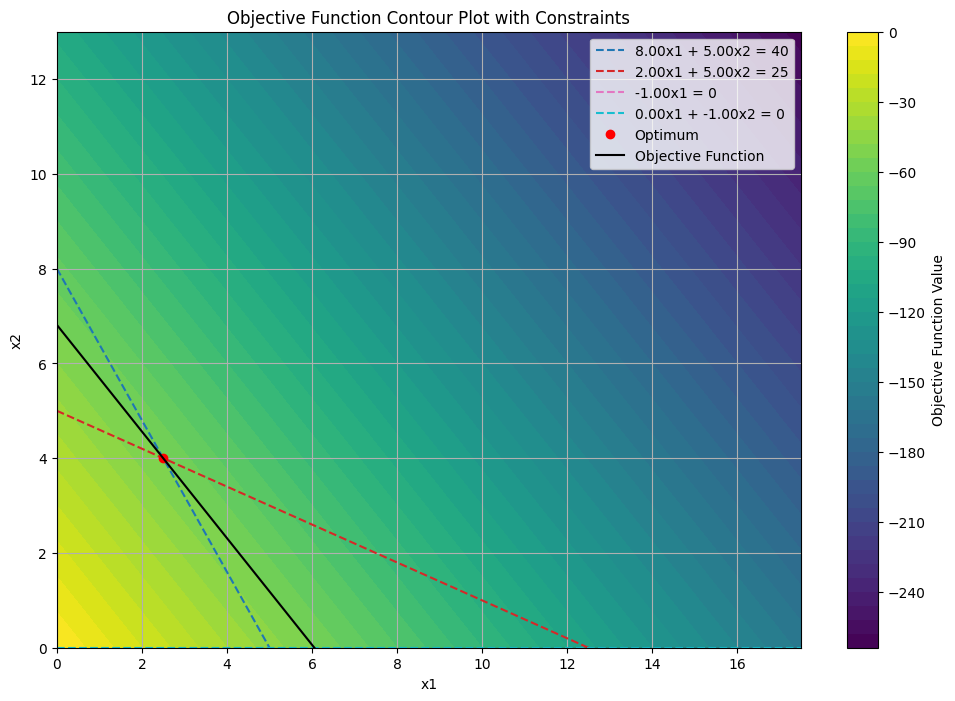

In [7]:
def zad1():
    # Wartości początkowe
        # I, II
    x0 = [0, 0]
    zysk = [9, 8]

    # Definicja ograniczeń 
    # ([a, b], c) oznacza a*x1 + b*x2 <= c
    constraints = [
        ([8, 5], 40),   # Ograniczenie zużycia surowca A
        ([2, 5], 25),   # Ograniczenie zużycia surowca B
        ([-1, 0], 0),   # Ograniczenie nieujemności x_1
        ([0, -1], 0)    # Ograniczenie nieujemności x_2
    ]

    print_optimization_results(x0, zysk, constraints)

zad1()

In [8]:
def knapsack(weights, values, max_weight):
    n = len(weights)
    dp = [[0 for _ in range(max_weight + 1)] for _ in range(n + 1)]
    keep = [[0 for _ in range(max_weight + 1)] for _ in range(n + 1)]

    for i in range(1, n + 1):
        for w in range(max_weight + 1):
            if weights[i-1] <= w:
                if dp[i-1][w] < dp[i-1][w-weights[i-1]] + values[i-1]:
                    dp[i][w] = dp[i-1][w-weights[i-1]] + values[i-1]
                    keep[i][w] = 1
                else:
                    dp[i][w] = dp[i-1][w]
            else:
                dp[i][w] = dp[i-1][w]

    # Backtrack to find the items to include in the knapsack
    w = max_weight
    selected_items = [0] * n
    for i in range(n, 0, -1):
        if keep[i][w] == 1:
            selected_items[i-1] += 1
            w -= weights[i-1]

    return dp[n][max_weight], selected_items

# Define the weights and values
weights = [4, 2, 6, 5]
values = [5, 3, 4, 8]
max_weight = 12

# Get the maximum value and the selected items
max_value, selected_items = knapsack(weights, values, max_weight)
print("Maximum value:", max_value)
print("Selected items:", selected_items)

Maximum value: 16
Selected items: [1, 1, 0, 1]
